In [1]:
# for fast autocomplete
%config Completer.use_jedi = False

In [2]:
import os

import tqdm

# data handling
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from nba_api.stats.static import teams as nba_api_teams

# plotting
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# image handling
from PIL import Image
import requests
from cairosvg import svg2png
from io import BytesIO

## parse nba2k ratings

In [3]:
# parse nba2k ratings

year = None
on_players = False
on_teams = False
info = dict()
with open("nba2k_ratings.txt", 'r') as fp:
    for line in fp:
        if len(line.strip()) == 0:
            continue
        if "### YEAR" in line:
            year = line.split(":")[1].strip()
            info[year] = {"teams": [], "players": []}
        elif "#### PLAYERS" in line:
            on_players = True
            on_teams = False
        elif "#### TEAMS" in line:
            on_players = False
            on_teams = True
        elif on_players:
            _line = line.split()
            rank = int(_line[0].split(".")[0])
            rating = float(_line[-1])
            name = " ".join(_line[1:-1])
            info[year]["players"].append(dict(
                name=name,
                rank_2k=rank,
                rating_2k=rating,
            ))
        elif on_teams:
            _line = line.split()
            rank = int(_line[0].split(".")[0])
            rating = float(_line[-1])
            name = " ".join(_line[1:-1])
            info[year]["teams"].append(dict(
                name=name,
                rank_2k=rank,
                rating_2k=rating,
            ))
nba2k_info = info
del info

In [4]:
# fns to turn info dataframes

def nba2k_team_year_df(year):
    year = str(year)
    df = pd.DataFrame(nba2k_info[year]["teams"])
    df["year"] = year
    return df

def nba2k_player_year_df(year):
    year = str(year)
    df = pd.DataFrame(nba2k_info[year]["players"])
    df["year"] = year
    return df

In [5]:
# examples
team_df = nba2k_team_year_df(2021)
print(team_df.head())

player_df = nba2k_player_year_df(2021)
print(player_df.head())

                   name  rank_2k  rating_2k  year
0  Los Angeles Clippers        1       77.2  2021
1      Dallas Mavericks        2       76.6  2021
2    Los Angeles Lakers        2       76.6  2021
3    Philadelphia 76ers        4       76.4  2021
4       Milwaukee Bucks        5       76.2  2021
                    name  rank_2k  rating_2k  year
0  Giannis Antetokounmpo        1       97.0  2021
1           LeBron James        1       97.0  2021
2           James Harden        3       96.0  2021
3          Kawhi Leonard        3       96.0  2021
4          Anthony Davis        5       95.0  2021


## parse nba standings

In [6]:
# NOTE: super hacky and depends on the file being the exact format i copy and pasted in,
#       as if very much depends on lines that come before in a certain order

year = None
conference = None
team = None
info = dict()
after_logo = None
after_team = None

with open("nba_standings.txt", 'r') as fp:
    for line in fp:
        if len(line.split()) == 0:
            continue
        elif "### YEAR" in line:
            year = line.split()[-1].strip()
            info[year] = []
        elif "Eastern Conference" in line:
            conference = "east"
        elif "Western Conference" in line:
            conference = "west"
        elif len(line.strip()) < 3:
            conf_rank = int(line.strip())
        elif "Logo" in line:
            after_logo = True
            info[year].append(dict())
            team_dict = info[year][-1]
            team_dict["conference_rank"] = conf_rank
            team_dict["conference"] = conference
        elif after_logo:
            team = line.split("-")[0].strip()
            team_dict["name"] = team
            after_logo = False
            after_team = True
        elif after_team:
            _line = line.split()
            team_dict["wins"] = _line[0]
            team_dict["losses"] = _line[1]
            team_dict["win_pct"] = _line[2]
            after_team = False
            
standings_info = info
del info

In [7]:
# fns to turn info dataframes
def standings_team_year_df(year):
    year = str(year)
    df = pd.DataFrame(standings_info[year])
    df["year"] = year
    df["overall_rank"] = df["win_pct"].rank(ascending=False)
    
    return df

In [8]:
standings_df = standings_team_year_df(2021)
print(standings_df.head())

   conference_rank conference                name wins losses win_pct  year  \
0                1       east  Philadelphia 76ers   49     23   0.681  2021   
1                2       east       Brooklyn Nets   48     24   0.667  2021   
2                3       east     Milwaukee Bucks   46     26   0.639  2021   
3                4       east     New York Knicks   41     31   0.569  2021   
4                5       east       Atlanta Hawks   41     31   0.569  2021   

   overall_rank  
0           3.0  
1           4.0  
2           7.0  
3          11.5  
4          11.5  


## merge data

In [9]:
def team_merged_df(year):
    df_2k = nba2k_team_year_df(year)
    df_standings = standings_team_year_df(year)
    df = pd.merge(
        df_2k, 
        df_standings, 
        on="name", 
        suffixes=("_2k", "_standings"))
    return df

## plot

In [10]:
def plot_year_graph(year, xcol, ycol):
    df = team_merged_df(year)
    ax = df.plot.scatter(x=xcol, y=ycol)
    ax.set_title(year)

    for i, point in df.iterrows():
        x, y = point[xcol], point[ycol]
        ax.text(x, y, point["name"].split()[0].strip())
        
    # add linear regression line
    x = df[xcol].values.reshape(-1, 1)
    y = df[ycol].values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)
    ypred = lm.predict(x)
    score = lm.score(x, y)
    print(score)
    ax.plot(df[xcol], ypred, 'r')
    return ax

0.1817307776584547


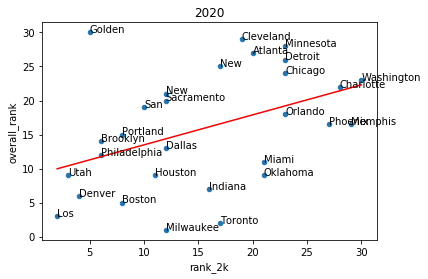

0.2777871141275555


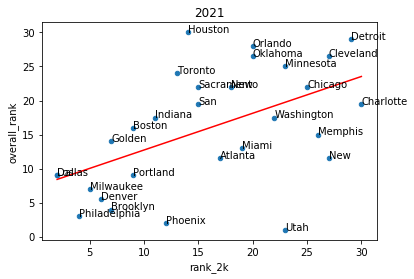

In [11]:
ax = plot_year_graph(2020, "rank_2k", "overall_rank")
plt.show()

ax = plot_year_graph(2021, "rank_2k", "overall_rank")
plt.show()

In [12]:
merged_df = team_merged_df(2021)
print(merged_df.head())

                 name  rank_2k  rating_2k year_2k  conference_rank conference  \
0    Dallas Mavericks        2       76.6    2021                5       west   
1  Los Angeles Lakers        2       76.6    2021                7       west   
2  Philadelphia 76ers        4       76.4    2021                1       east   
3     Milwaukee Bucks        5       76.2    2021                3       east   
4      Denver Nuggets        6       76.0    2021                3       west   

  wins losses win_pct year_standings  overall_rank  
0   42     30   0.583           2021           9.0  
1   42     30   0.583           2021           9.0  
2   49     23   0.681           2021           3.0  
3   46     26   0.639           2021           7.0  
4   47     25   0.653           2021           5.5  


## using team logos

### download logos

In [13]:
teams = nba_api_teams.get_teams()
teams[0]

{'id': 1610612737,
 'full_name': 'Atlanta Hawks',
 'abbreviation': 'ATL',
 'nickname': 'Hawks',
 'city': 'Atlanta',
 'state': 'Atlanta',
 'year_founded': 1949}

In [14]:
# NOTE: naming is weird because logotyp didn't use consistent naming
replace = [
    "pelicans",
    "warriors",
    "spurs",
    "timberwolves",
    "76ers",
    "clippers",
]

def get_logo(name):
    try:
#         print(f"downloading {name}...")
        url = "https://logotyp.us/files/" + f"{name}.svg"
        res = requests.get(url)
        out = BytesIO()
        png = svg2png(res.content, write_to=out)
        im = Image.open(out)
#         print(f"{name} download successful")
        return im
    except:
        print(f"{name} failed!")
        import pdb; pdb.set_trace()

def get_logos():
    teams = nba_api_teams.get_teams()
    ims = dict()
    for team in tqdm.tqdm(teams):
        if "clippers" in team["nickname"].lower():
            name = "la-clippers"
        elif team["nickname"].lower() in replace:
            name = team["nickname"].lower().strip()
        else:
            name = team["full_name"].lower().strip().replace(" ", "-")
        im = get_logo(name)
        ims[team["full_name"]] = im
    return ims

In [15]:
ims = get_logos()

100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


### scatterplot + regress

In [16]:
x = "rank_2k"
y = "overall_rank"

def team_logo_scatterplot(
    year, 
    xcol,
    ycol,
    xlab=None,
    ylab=None,
    title=None,
    lr=True,
    loc=None,
):
    title = title or str(year)
    xlab = xlab or xcol
    ylab = ylab or ycol
    
    df = team_merged_df(year)
    
    # HACK: doing this because want higher ranked higher up that axes
    df[xcol] *= -1.
    df[ycol] *= -1.
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12., 12.)
    
    # add team logos for scatterplot
    for i, point in tqdm.tqdm(df.iterrows()):
        im = ims[point["name"]]
        x, y = point[xcol], point[ycol]
        im2 = OffsetImage(im, zoom=0.15, alpha=0.6)
        ab = AnnotationBbox(im2, (x, y), frameon=False,)
        ax.add_artist(ab)
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        
    plt.title(title + "\n", fontsize=24)
    if lr:
        x = df[xcol].values.reshape(-1, 1)
        y = df[ycol].values.reshape(-1, 1)
        # add regression line
        # add linear regression line
        lm = LinearRegression().fit(x, y)
        ypred = lm.predict(x)
        r2 = lm.score(x, y)
        xs = np.linspace(*ax.get_xlim())
        ys = np.linspace(*ax.get_ylim())
        ideal_line = ax.plot(xs, ys,
            color="k", linestyle=":", label="ideal prediction")
        fit_line = ax.plot(
            df[xcol], ypred, color='r', label="2k prediction")
        
        ax.legend(fontsize=18, loc=loc)
        
        plt.suptitle(f"\n\n\n($r^2={r2:0.2f}$)", fontsize=18)
        

    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    return fig, ax

29it [00:00, 268.20it/s]
30it [00:00, 309.14it/s]
29it [00:00, 309.22it/s]
29it [00:00, 289.53it/s]
29it [00:00, 138.16it/s]
29it [00:00, 300.58it/s]
29it [00:00, 297.15it/s]
29it [00:00, 306.55it/s]


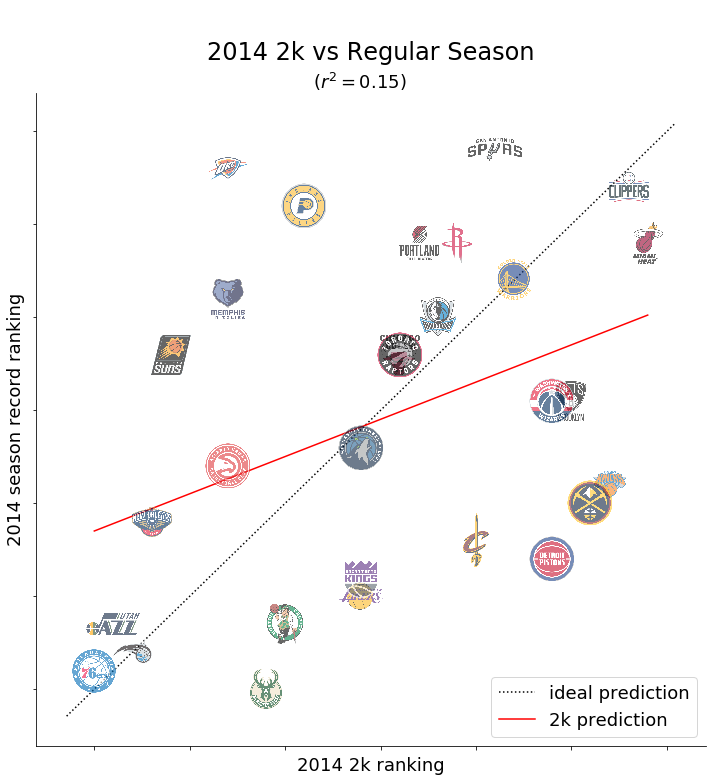

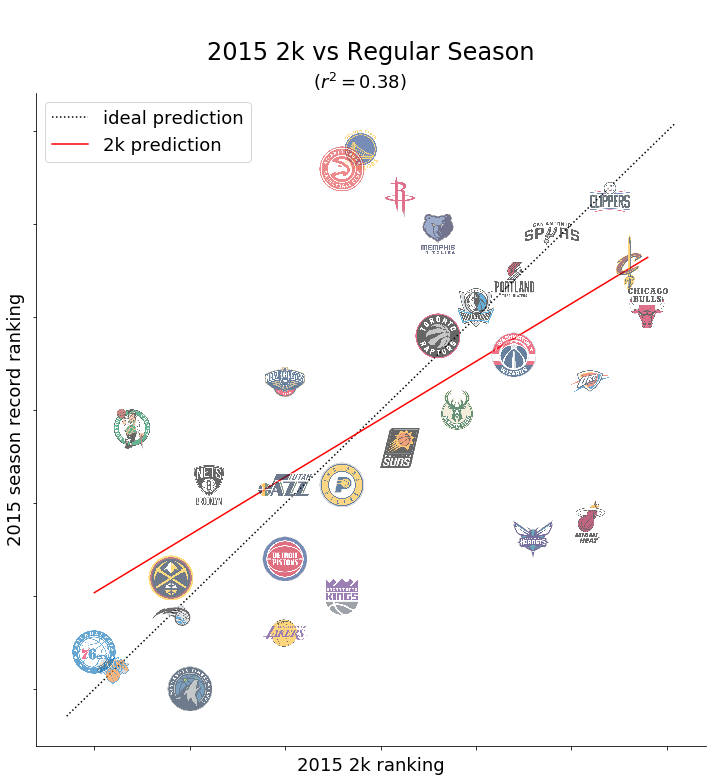

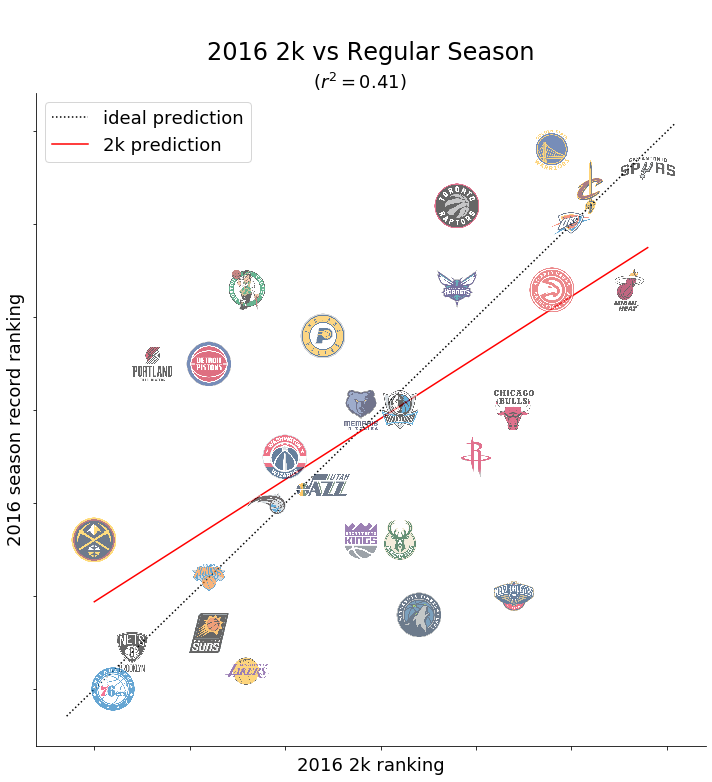

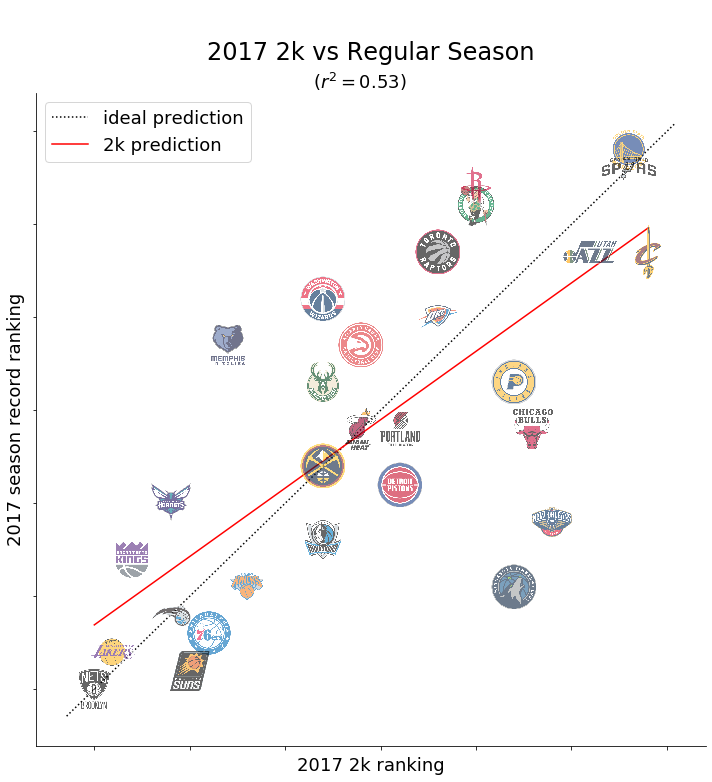

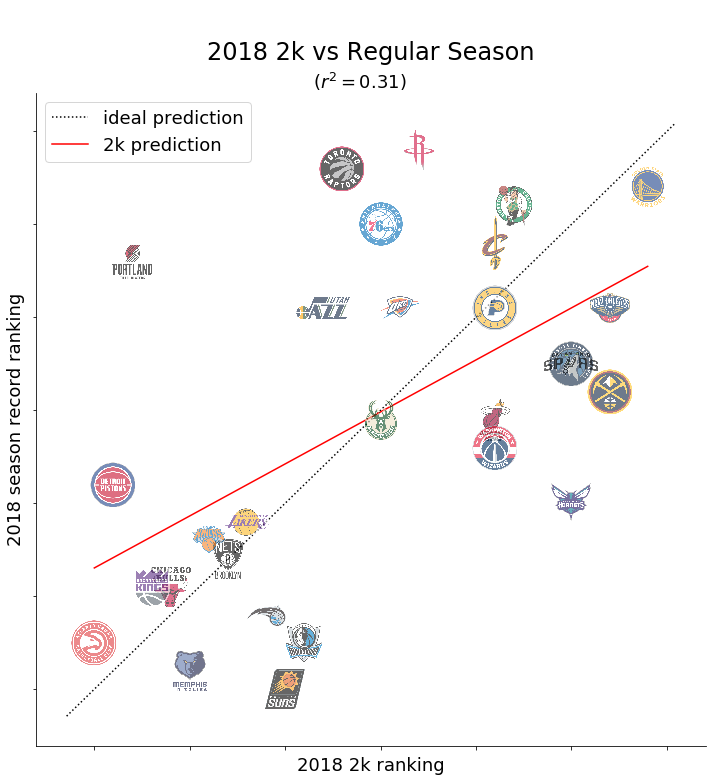

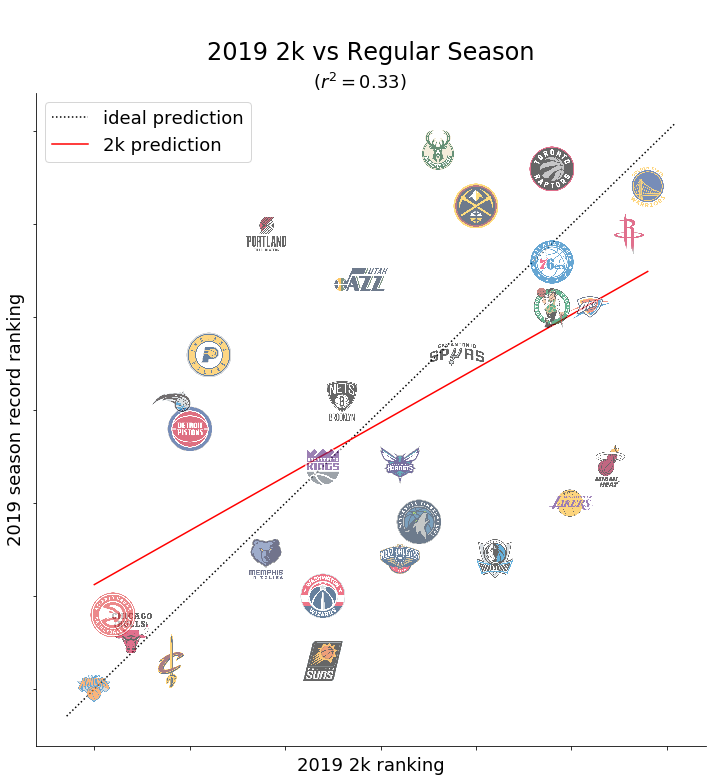

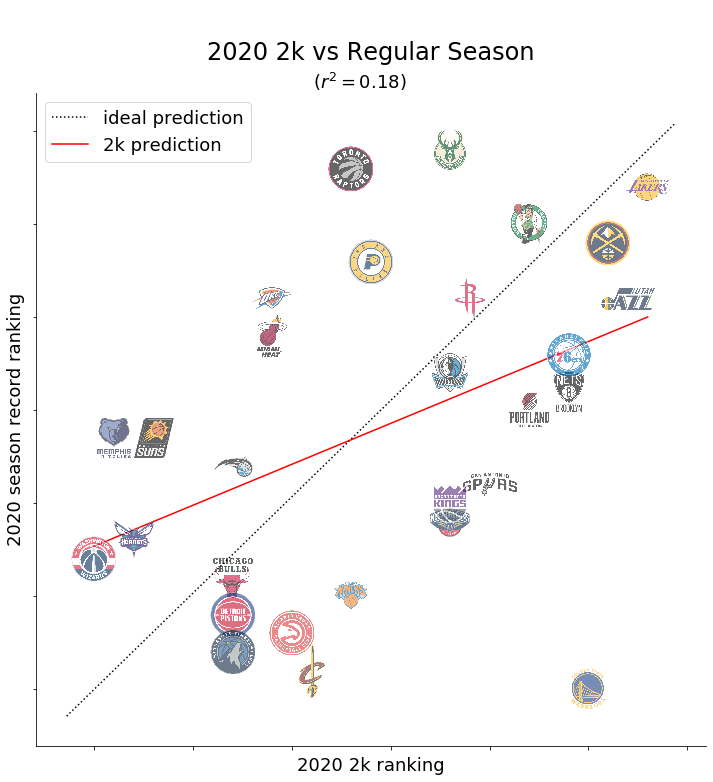

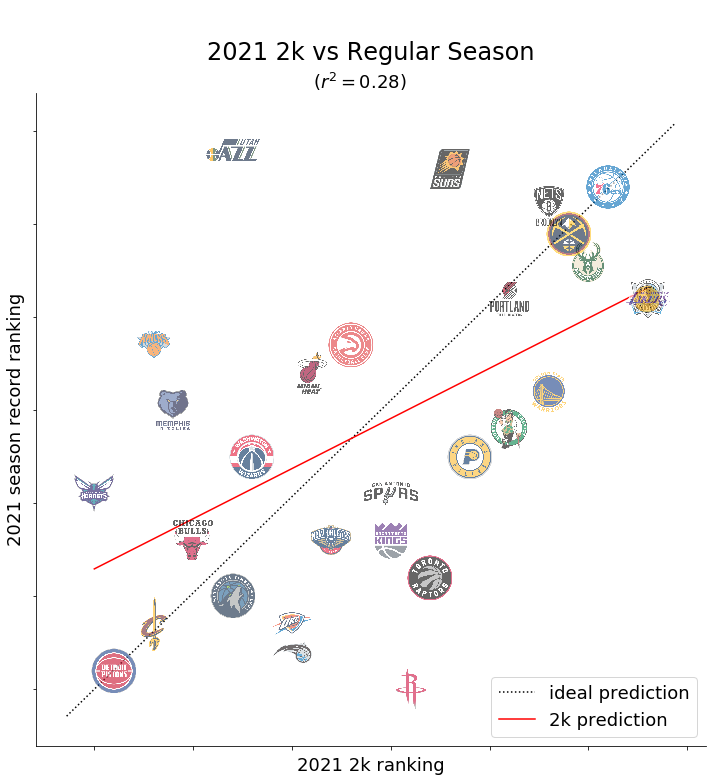

In [18]:
xcol = "rank_2k"
ycol = "overall_rank"

figs, axes = [], []
for year in range(2014, 2022):
    loc = "upper left" if year not in [2014, 2021] else "lower right"
    fig, ax = team_logo_scatterplot(
        year=year,
        xcol=xcol,
        ycol=ycol,
        xlab=f"{year} 2k ranking",
        ylab=f"{year} season record ranking",
        title=f"{year} 2k vs Regular Season",
        lr=True,
        loc=loc,
    )
    figs.append(fig)
    axes.append(ax)
    fig.savefig(f"plots/rank_2k_vs_rank_season_{year}.png")